In [73]:
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt

In [74]:
def load_partial(folder, height, batchsize, overlap):
    lowerh = 0
    upperh = batchsize
    partial = []
    while(height-upperh >= batchsize):
        p = np.load(os.path.join(folder, str(lowerh)+'to'+str(upperh)) + '.npy')
        partial.append(p)
        lowerh = upperh - overlap
        upperh = lowerh + batchsize
    p = np.load(os.path.join(folder, str(lowerh)+'to'+str(height)) + '.npy')
    partial.append(p)
    return partial

def stitch(partial, height, batchsize, overlap):
    lowerh = 0
    upperh = batchsize
    full = np.full((height, partial[0].shape[1]), -1)
    hoverlap = overlap/2
    i = 0
    while(height-upperh >= batchsize):
        # print(lowerh, upperh)
        if(lowerh==0):
            full[int(lowerh):int(upperh-hoverlap)] = partial[i][0:int(batchsize-hoverlap)]
        else:
            full[int(lowerh+hoverlap):int(upperh-hoverlap)] = partial[i][int(hoverlap):int(batchsize-hoverlap)]
        lowerh = upperh - overlap
        upperh = lowerh + batchsize
        i+=1
    full[int(lowerh+hoverlap):] = partial[i][int(hoverlap):]
    return full

In [191]:
def interpolate(disparity, maxdisp):
    average = np.average(disparity[:,0:-maxdisp])
    for i in range(disparity.shape[0]):
        interpolate=False
        start = -1
        startval = -1
        end = -1
        endval = -1
        for j in range(disparity.shape[1]-maxdisp):
            if(interpolate==False and disparity[i,j] == -1):
                interpolate = True
                start = j
                if(j-1 <0):
                    startval=average
                else:
                    startval = disparity[i,j-1]
            if(interpolate==True and disparity[i,j] != -1):
                interpolate = False
                end = j
                endval = disparity[i,j]
                values = np.arange(1,end-start+1)
                values = values**2 * (endval-startval)/((end-start+1)**2) + startval
                disparity[i,start:end] = values
                interpolate = False
        if(interpolate==True):
            endval = startval
            end = disparity.shape[1]-maxdisp-1
            values = np.arange(1,end-start+1)
            values = values * (endval-startval)/(end-start+1) + startval
            disparity[i,start:end] = values
            interpolate = False
    


In [123]:
def dof_blur(color_image, disparity_map, disp_in_focus, levels=10, blurrness=1.5):
    # Simulate depth of field effect
    # 
    # Inputs:
    # color_image - the rgb image to apply dof effect on
    # disparity_map - the disparity map of the rgb image, 
    #                 should be aligned with the rgb image
    # disp_in_focus - the disparity of the plane in focus
    # levels - the number of disparity ranges to consider
    # blurrness - how strong the blurrness is if not in focus
    # 
    # Output:
    # Blurred image simulating depth of field effect

    h, w = color_image.shape[:2]
    disp_to_focus_map = np.abs(disparity_map - disp_in_focus)
    # plt.imshow(disp_to_focus_map / np.max(disp_to_focus_map))
    # plt.show()
    disp_min = np.min(disp_to_focus_map)
    disp_max = np.max(disp_to_focus_map)
    print((disp_max - disp_min) // levels)
    disp_strips = np.arange(disp_min, disp_max, (disp_max - disp_min) / levels)
    disp_strips = np.append(disp_strips, [disp_max])
    # print(disp_strips)

    # blur color image according to different disparity
    result = color_image.copy()
    for i in range(1, disp_strips.shape[0]):
        disp_low = disp_strips[i-1]
        disp_high = disp_strips[i]
        
        k_size = 2 * i + 1
                                                                  # make the 2nd strip also in focus
        blurred = cv2.GaussianBlur(color_image, (k_size, k_size), (i / 1.5) ** blurrness - (1 / 1.5) ** 1.2)
        plt.imshow(blurred)
        # plt.show()
        loc = np.where(np.logical_and(disp_to_focus_map >= disp_low, disp_to_focus_map <= disp_high))
        # temp=np.zeros_like(disparity_map)
        # temp[loc] = 1
        # plt.imshow(temp)
        # plt.show()
        result[loc] = blurred[loc]
    return result

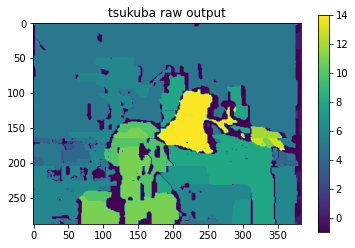

In [144]:
partial = load_partial("run\\tsukuba", 288, 50, 10)
full = stitch(partial, 288, 50, 10)
plt.imshow(full)
plt.colorbar()
plt.title("tsukuba raw output")
plt.savefig("Data/Experiment/tsukuba/raw_disparity.png", format="png", transparent=False)

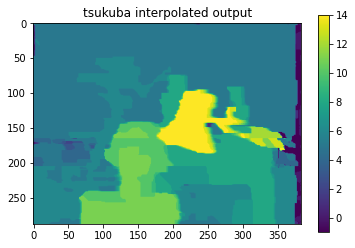

In [145]:
disp_reg = full
interpolate(disp_reg, 32)
plt.imshow(disp_reg.astype(int))
plt.colorbar()
plt.title("tsukuba interpolated output")
plt.savefig("Data/Experiment/tsukuba/interpolated_disparity.png", format="png", transparent=False)

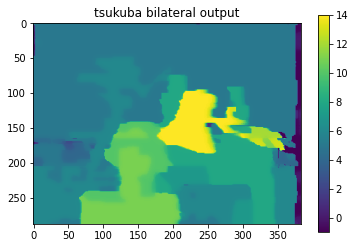

In [174]:
disp_bilat = cv2.bilateralFilter(disp_reg.astype(np.float32), 0, 0, 5)
plt.imshow(disp_bilat)
plt.colorbar()
plt.title("tsukuba bilateral output")
plt.savefig("Data/Experiment/tsukuba/bilateral_disparity.png", format="png", transparent=False)

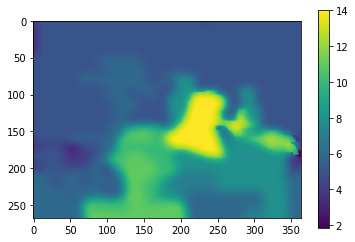

In [82]:

disp_bilat = disp_bilat[:-20, :-20]
plt.imshow(disp_bilat)
plt.colorbar()
plt.show()

In [53]:
partial3 = load_partial("run\\mask", 287, 40, 8)
full3 = stitch(partial3, 287, 40, 8)

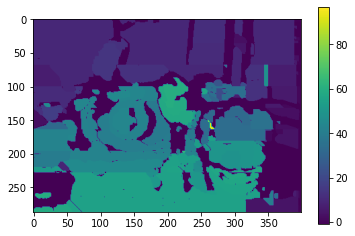

In [54]:
plt.imshow(full3)
plt.colorbar()

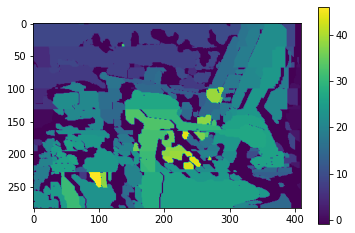

In [56]:
partial4 = load_partial("run\\Adirondack", 283, 40, 8)
full4 = stitch(partial4, 283, 40, 8)
plt.imshow(full4)
plt.colorbar()

(60, 423)


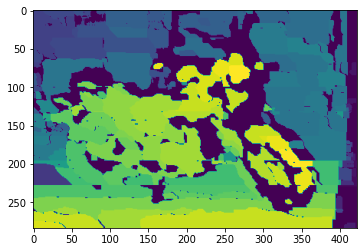

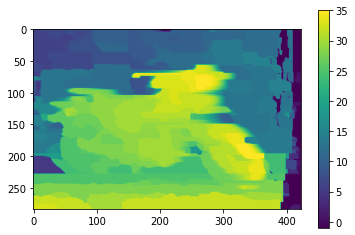

In [195]:
partial5 = load_partial("run\\Motorcycle", 284, 40, 8)
print(partial5[-1].shape)
full5 = stitch(partial5, 284, 40, 8)
plt.imshow(full5)
plt.show()
inter5 = full5
interpolate(inter5,48)
plt.imshow(inter5)
plt.colorbar()

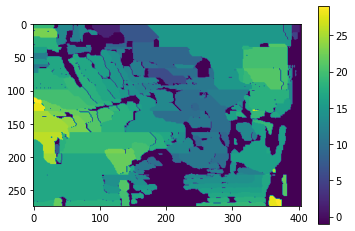

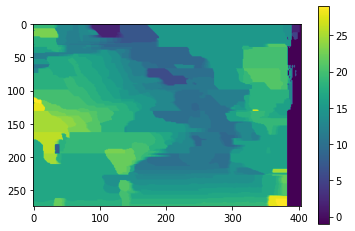

In [232]:
partial6 = load_partial("run\\Piano", 275, 40, 8)
full6 = stitch(partial6, 275, 40, 8)
plt.imshow(full6)
plt.colorbar()
plt.show()
inter6 = full6
interpolate(inter6,20)
plt.imshow(inter6)
plt.colorbar()

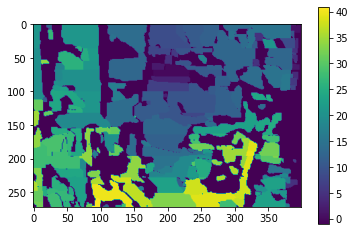

In [68]:
partial7 = load_partial("run\\Playroom", 272, 40, 8)
full7 = stitch(partial7, 272, 40, 8)
plt.imshow(full7)
plt.colorbar()

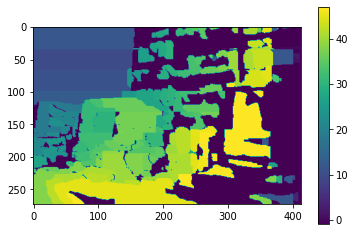

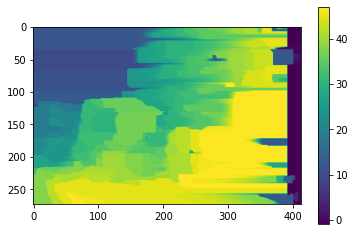

In [193]:
partial8 = load_partial("run\\Vintage", 274, 40, 8)
full8 = stitch(partial8, 274, 40, 8)
plt.imshow(full8)
plt.colorbar()
plt.show()
inter8 = full8
interpolate(inter8,20)
plt.imshow(inter8)
plt.colorbar()

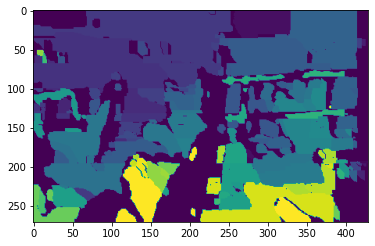

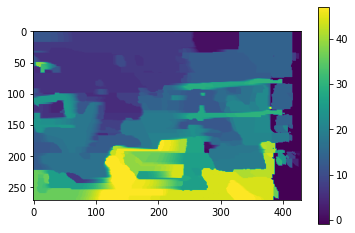

In [187]:
partial9 = load_partial("run\\Classroom2", 271, 40, 8)
full9 = stitch(partial9, 271, 40, 8)
plt.imshow(full9)
plt.show()
inter9 = full9
interpolate(inter9,48)
plt.imshow(inter9)
plt.colorbar()

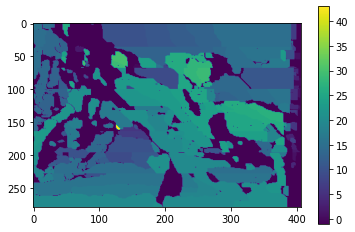

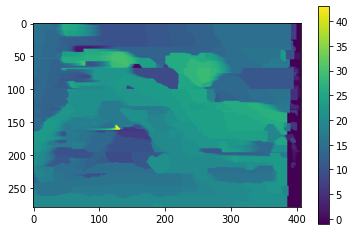

In [194]:
partial10 = load_partial("run\\Bicycle2", 279, 40, 8)
full10 = stitch(partial10, 279, 40, 8)
plt.imshow(full10)
plt.colorbar()
plt.show()
inter10 = full10
interpolate(inter10,20)
plt.imshow(inter10)
plt.colorbar()

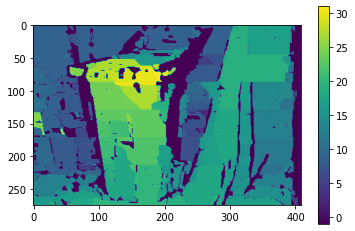

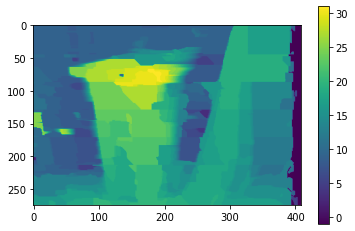

In [261]:
partial1 = load_partial("run\\recycle2", 275, 50, 8)
full1 = stitch(partial1, 275, 50, 8)
plt.imshow(full1)
plt.colorbar()
plt.show()
inter1 = full1
interpolate(inter1,20)
plt.imshow(inter1)
plt.colorbar()

(1952, 2852, 3)


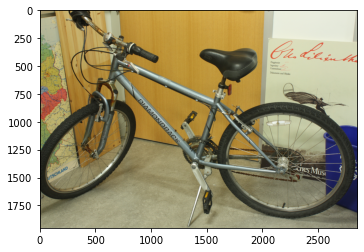

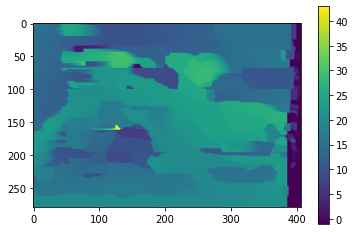

In [273]:
img = plt.imread("Middlebury/MiddEval3-data-F/MiddEval3/testF/Bicycle2/im1.png")
print(img.shape)
plt.imshow(img)
plt.show()
disp_bilat = cv2.bilateralFilter(inter10.astype(np.float32), 0, 0, 10)
plt.imshow(disp_bilat)
plt.colorbar()
plt.savefig("Data/Experiment/Bicycle2/disp.png", format="png", transparent=False)

3.0


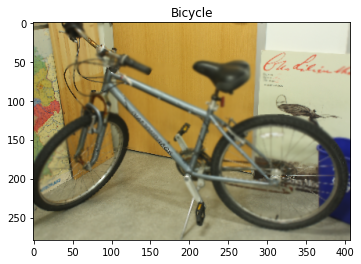

In [276]:
img_blur = dof_blur(cv2.resize(img, (disp_bilat.shape[1], disp_bilat.shape[0])), disp_bilat, disp_in_focus=10, levels=10, blurrness=0.5)
plt.imshow(img_blur)
plt.title("Bicycle")
plt.savefig("Data/Experiment/Bicycle2/blur_bilat_10")